In [1]:
# Import the modules
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

---

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
import os
import csv
file_path = os.path.join("clean_loan_data.csv")

## Data Preprocessing



### Step 1: Read the `loan.csv` data from the `Resources` folder into a Pandas DataFrame.

In [3]:
# Read the CSV file from the Resources folder into a Pandas DataFrame
#file_path = Path(f'{path}loan.csv')
loan_data = pd.read_csv(file_path)

# Review the DataFrame
loan_data

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,146.41,360,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.00,360,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.00,360,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.00,360,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.00,360,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
594,Female,No,0,Graduate,No,2900,0.0,71.00,360,1.0,Rural,Y
595,Male,Yes,3+,Graduate,No,4106,0.0,40.00,180,1.0,Rural,Y
596,Male,Yes,1,Graduate,No,8072,240.0,253.00,360,1.0,Urban,Y
597,Male,Yes,2,Graduate,No,7583,0.0,187.00,360,1.0,Urban,Y


In [4]:
# Separately transforming the Loan_Status column without using OHE, since it needs to remain in one copy
loan_data['Loan_Status'] = loan_data['Loan_Status'].map({'N': 0, 'Y': 1})

# Split to train and test. Splitting before knn imputing required for fitting imputer on train and fill NaNs using it on test
df_train, df_test = train_test_split(loan_data, test_size=0.2, random_state=1)

In [5]:
# # Separately transforming the Loan_Status column without using OHE, since it needs to remain in one copy

# loan_data['Loan_Status'] = loan_data['Loan_Status'].map({'N': 0, 'Y': 1})
# loan_data

In [6]:
# Looking at the missing values
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             586 non-null    object 
 1   Married            599 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          599 non-null    object 
 4   Self_Employed      567 non-null    object 
 5   ApplicantIncome    599 non-null    int64  
 6   CoapplicantIncome  599 non-null    float64
 7   LoanAmount         599 non-null    float64
 8   Loan_Amount_Term   599 non-null    int64  
 9   Credit_History     549 non-null    float64
 10  Property_Area      599 non-null    object 
 11  Loan_Status        599 non-null    int64  
dtypes: float64(3), int64(3), object(6)
memory usage: 56.3+ KB


In [7]:
# get categorical and numerical columns
categorical_columns = loan_data.select_dtypes(include=['object', 'category']).columns
numerical_columns = loan_data.select_dtypes(include=['int64', 'float64']).columns


In [8]:
#Impute missing values for continuous data only (LoanAmount, Loan_Amount_Term)

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)

# Apply the KNN imputer to the numerical columns
df_train[numerical_columns] = imputer.fit_transform(df_train[numerical_columns])

# apply to test !IMPORTANT! for prevent data leak
df_test[numerical_columns] = imputer.transform(df_test[numerical_columns])



In [9]:
# Looking at the number of unique values ​​of categorical variables; if there are few of them, this allows us to use OHE
for i in categorical_columns:
    print(i, loan_data[i].nunique())

Gender 2
Married 2
Dependents 4
Education 2
Self_Employed 2
Property_Area 3


In [10]:
# Change all categorical columns to binary using get dummies
clean_train_df = pd.get_dummies(df_train, columns=['Gender','Married','Dependents','Education',
                                                    'Self_Employed','Property_Area'])
clean_test_df = pd.get_dummies(df_test, columns=['Gender','Married','Dependents','Education',
                                                    'Self_Employed','Property_Area'])

### Step 2: Create the labels set (`y`)  from the “loan_status” column, and then create the features (`X`) DataFrame from the remaining columns.

In [11]:
# Separate the data into labels and features
# Separate the y variable, the labels
y_train = clean_train_df['Loan_Status']
y_test = clean_test_df['Loan_Status']

# Separate the X variable, the features
X_train = clean_train_df.drop('Loan_Status', axis=1)
X_test = clean_test_df.drop('Loan_Status', axis=1)
print(y_train)
print(y_test)
print(X_train)
X_test

82     0.0
568    1.0
346    0.0
543    1.0
34     0.0
      ... 
129    1.0
144    1.0
72     1.0
235    1.0
37     1.0
Name: Loan_Status, Length: 479, dtype: float64
442    1.0
286    0.0
379    1.0
522    1.0
200    1.0
      ... 
5      1.0
223    1.0
159    0.0
38     1.0
192    0.0
Name: Loan_Status, Length: 120, dtype: float64
     ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
82            1378.0             1881.0       167.0             360.0   
568           3166.0                0.0        36.0             360.0   
346           3875.0                0.0        67.0             360.0   
543           2667.0             1625.0        84.0             360.0   
34           12500.0             3000.0       320.0             360.0   
..               ...                ...         ...               ...   
129           2718.0                0.0        70.0             360.0   
144           1538.0             1425.0        30.0             360.0   
72     

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
442,7085.0,0.0,84.0,360.0,1.0,False,True,True,False,True,False,False,False,True,False,False,True,False,True,False
286,4400.0,0.0,127.0,360.0,0.0,False,True,False,True,False,False,True,False,True,False,True,False,False,True,False
379,9167.0,0.0,185.0,360.0,1.0,False,True,True,False,False,False,False,True,True,False,True,False,True,False,False
522,2550.0,2042.0,126.0,360.0,1.0,False,True,True,False,True,False,False,False,False,True,False,False,True,False,False
200,3500.0,1083.0,135.0,360.0,1.0,False,True,False,True,False,True,False,False,False,True,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,5417.0,4196.0,267.0,360.0,1.0,False,True,False,True,False,False,True,False,True,False,False,True,False,False,True
223,6250.0,1695.0,210.0,360.0,1.0,False,True,False,True,False,False,True,False,True,False,True,False,False,True,False
159,3089.0,1280.0,121.0,360.0,0.0,False,True,False,True,False,True,False,False,True,False,True,False,False,True,False
38,4166.0,7210.0,184.0,360.0,1.0,False,True,True,False,True,False,False,False,True,False,True,False,False,False,True


---

## Create a Linear Regression Model with the Original Data

In [12]:
# Import required libraries
import numpy as np
import pandas as pd
import hvplot.pandas
from pathlib import Path
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns


### Visual Examinations of Numerical Columns

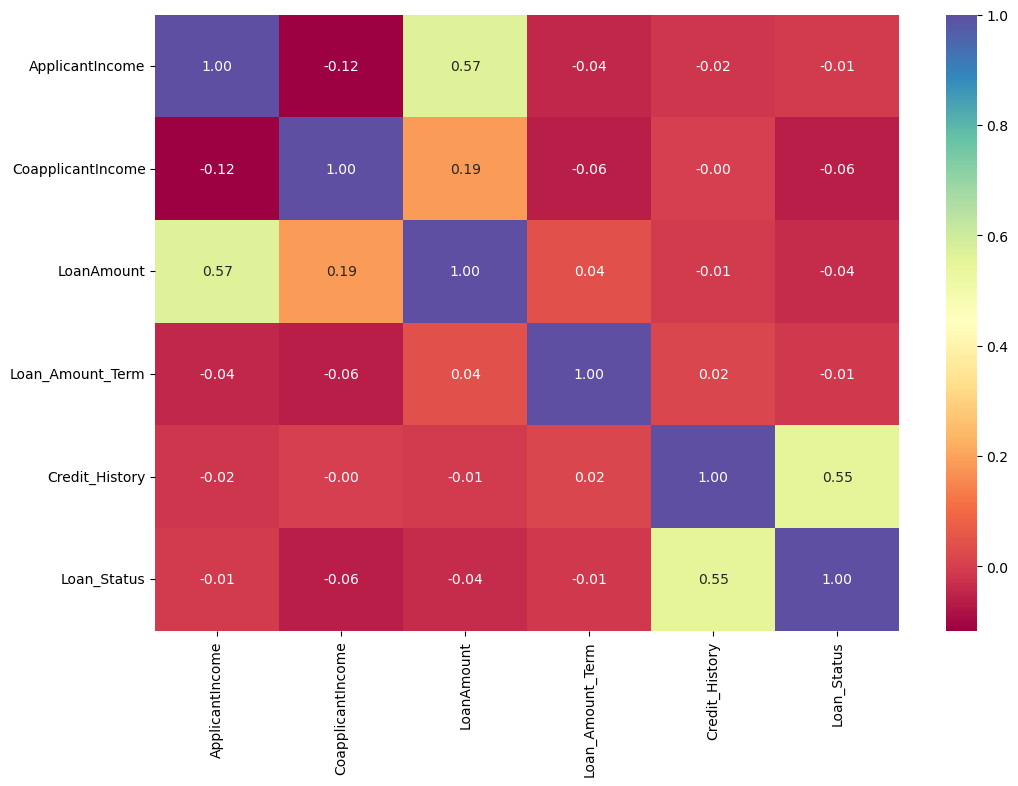

In [13]:
# Creating heatmap to visualize the relationship between numerical variables

loan_data = loan_data.dropna(subset='LoanAmount')
cols_list = loan_data.select_dtypes(include = np.number).columns.tolist()

plt.figure(figsize = (12, 8))
cmap = sns.diverging_palette(230, 20, as_cmap = True)
sns.heatmap(loan_data[cols_list].corr(), annot = True, fmt = '.2f', cmap = 'Spectral')
plt.show()


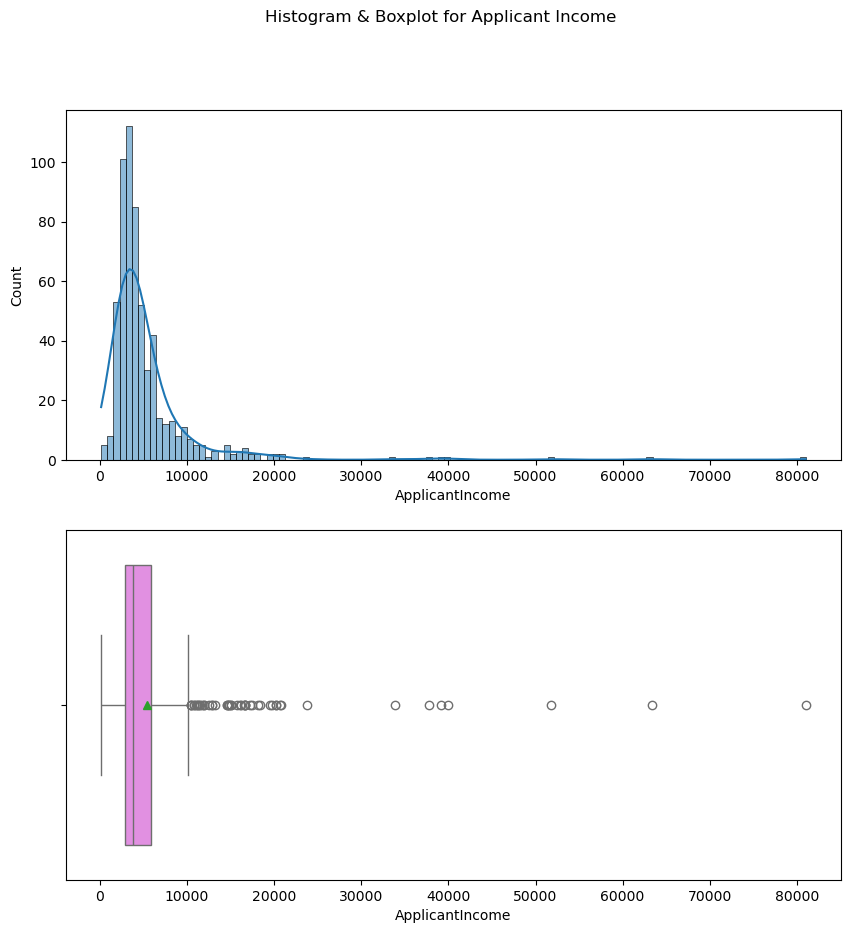

In [14]:
# Heatmap reveals postive correlations between ApplicantIncome v. LoanAmount and CoapplicantIncome v. LoanAmount 
# Begin histogram and boxplot review of ApplicantIncome

fig, axes = plt.subplots(2, 1, figsize = (10, 10))
fig.suptitle('Histogram & Boxplot for Applicant Income')
sns.histplot(data=loan_data, x = 'ApplicantIncome', kde = True, ax = axes[0]);
sns.boxplot(data=loan_data, x='ApplicantIncome', ax = axes[1], showmeans = True, color = "violet")
plt.show()

In [15]:
# Defining upper boudary for outliers as $30k
# Finding the indices having values greater than the upper boundary
print('Upper boundary')
outliers = print(loan_data.index[loan_data['ApplicantIncome'] > 30000])

Upper boundary
Index([152, 168, 180, 182, 325, 398, 431], dtype='int64')


In [16]:
loan_data_no_outliers = loan_data.drop([152, 168, 180, 182, 325, 398, 431]).reset_index(drop=True)

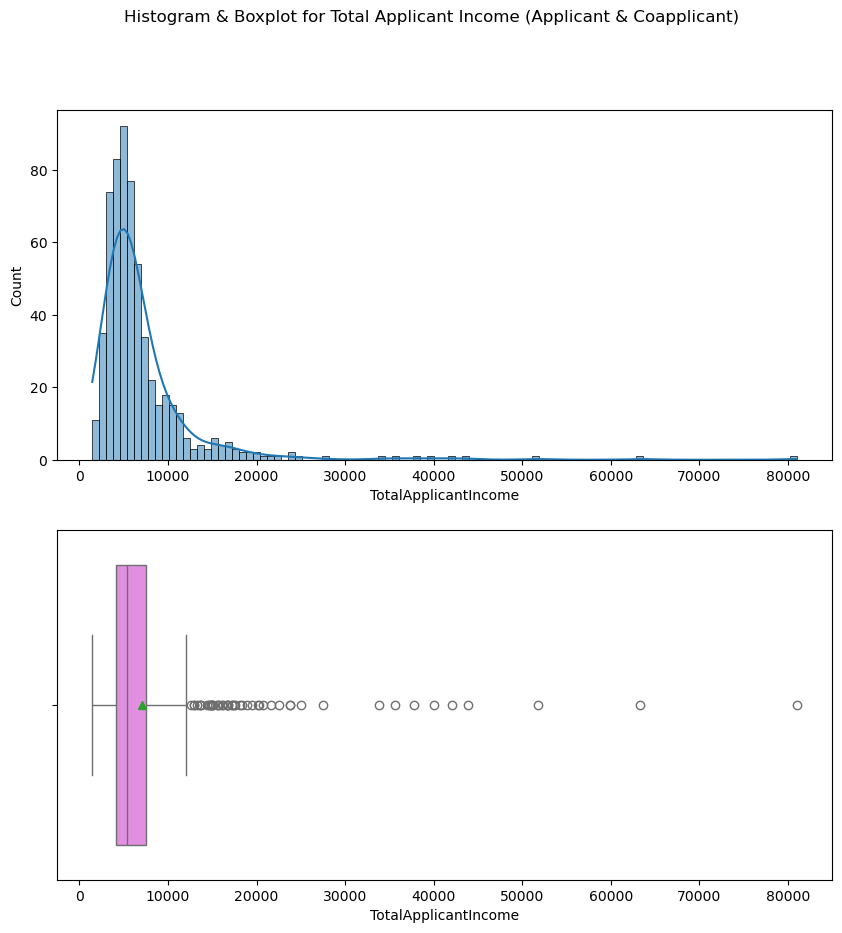

In [17]:
# Create a TotalApplicantIncome column as the sum of ApplicantIncome and CoapplicantIncome
loan_data['TotalApplicantIncome'] = loan_data['ApplicantIncome'] + loan_data['CoapplicantIncome']

# Begin histogram and boxplot review of TotalApplicantIncome

fig, axes = plt.subplots(2, 1, figsize = (10, 10))
fig.suptitle('Histogram & Boxplot for Total Applicant Income (Applicant & Coapplicant)')
sns.histplot(data=loan_data, x = 'TotalApplicantIncome', kde = True, ax = axes[0]);
sns.boxplot(data=loan_data, x='TotalApplicantIncome', ax = axes[1], showmeans = True, color = "violet")
plt.show()

In [18]:
# Defining upper boudary for outliers as $30k
# Finding the indices having values greater than the upper boundary
print('Upper boundary')
outliers = print(loan_data.index[loan_data['TotalApplicantIncome'] > 30000])


Upper boundary
Index([152, 168, 180, 182, 325, 398, 431, 567, 585], dtype='int64')


In [19]:
loan_data_no_outliers = loan_data_no_outliers.drop([152, 168, 180, 182, 325, 398, 431, 567, 585]).reset_index(drop=True)
loan_data_no_outliers

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,146.41,360,1.0,Urban,1
1,Male,Yes,1,Graduate,No,4583,1508.0,128.00,360,1.0,Rural,0
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.00,360,1.0,Urban,1
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.00,360,1.0,Urban,1
4,Male,No,0,Graduate,No,6000,0.0,141.00,360,1.0,Urban,1
...,...,...,...,...,...,...,...,...,...,...,...,...
578,Female,No,0,Graduate,No,2900,0.0,71.00,360,1.0,Rural,1
579,Male,Yes,3+,Graduate,No,4106,0.0,40.00,180,1.0,Rural,1
580,Male,Yes,1,Graduate,No,8072,240.0,253.00,360,1.0,Urban,1
581,Male,Yes,2,Graduate,No,7583,0.0,187.00,360,1.0,Urban,1


### First Linear Regression Model (Applicant Income v. Loan Amount)

In [20]:
# Reformat data of the independent variable ApplicantIncome as a single-column array
X = loan_data["ApplicantIncome"].values.reshape(-1, 1)


In [21]:
# Create an array for the dependent variable LoanAmount
y = loan_data["LoanAmount"]


In [22]:
# Create first model with scikit-learn
model = LinearRegression()

# Fit the data into the model
model.fit(X,y)

# Make predictions using the X set
predicted_y_values = model.predict(X)

In [23]:
# Import relevant metrics from scikit-learn
from sklearn.metrics import mean_squared_error, r2_score

# Compute metrics for the linear regression model: score, r2, mse, rmse, std
r2 = r2_score(y, predicted_y_values)
mse = mean_squared_error(y, predicted_y_values)
rmse = np.sqrt(mse)
std = np.std(y)

# Print relevant metrics.
print(f"The r2 is {r2}.")
print(f"The mean squared error is {mse}.")
print(f"The root mean squared error is {rmse}.")
print(f"The standard deviation is {std}.")

The r2 is 0.3213307824997683.
The mean squared error is 4882.185232270282.
The root mean squared error is 69.87263579020247.
The standard deviation is 84.81605152641346.


### Second Linear Regression Model (Total Income v. Loan Amount)

In [24]:
# Reformat data of the independent variable ApplicantIncome as a single-column array
X = loan_data["CoapplicantIncome"].values.reshape(-1, 1)


In [25]:
# Create second model with scikit-learn
model = LinearRegression()

# Fit the data into the model
model.fit(X,y)

# Make predictions using the X set
predicted_y_values = model.predict(X)

In [26]:
# Compute metrics for the linear regression model: score, r2, mse, rmse, std
r2 = r2_score(y, predicted_y_values)
mse = mean_squared_error(y, predicted_y_values)
rmse = np.sqrt(mse)
std = np.std(y)

# Print relevant metrics.
print(f"The r2 is {r2}.")
print(f"The mean squared error is {mse}.")
print(f"The root mean squared error is {rmse}.")
print(f"The standard deviation is {std}.")

The r2 is 0.03549767096426604.
The mean squared error is 6938.400778884516.
The root mean squared error is 83.29706344694581.
The standard deviation is 84.81605152641346.


### Third Linear Regression Model (Applicant Income v. Loan Amount) (No outliers)

In [27]:
# Reformat data of the independent variable ApplicantIncome as a single-column array
X = loan_data_no_outliers["ApplicantIncome"].values.reshape(-1, 1)
y = loan_data_no_outliers["LoanAmount"]


In [28]:
# Create third model with scikit-learn
model = LinearRegression()

# Fit the data into the model
model.fit(X,y)

# Make predictions using the X set
predicted_y_values = model.predict(X)

In [29]:
# Compute metrics for the linear regression model: score, r2, mse, rmse, std
r2 = r2_score(y, predicted_y_values)
mse = mean_squared_error(y, predicted_y_values)
rmse = np.sqrt(mse)
std = np.std(y)

# Print relevant metrics.
print(f"The r2 is {r2}.")
print(f"The mean squared error is {mse}.")
print(f"The root mean squared error is {rmse}.")
print(f"The standard deviation is {std}.")

The r2 is 0.3601093473182362.
The mean squared error is 3939.5638815961447.
The root mean squared error is 62.765945237813035.
The standard deviation is 78.46413483572802.


### Fourth Linear Regression Model (Total Income v. Loan Amount) (No outliers)

In [30]:
# Reformat data of the independent variable ApplicantIncome as a single-column array
X = loan_data_no_outliers["CoapplicantIncome"].values.reshape(-1, 1)


In [31]:
# Create fourth model with scikit-learn
model = LinearRegression()

# Fit the data into the model
model.fit(X,y)

# Make predictions using the X set
predicted_y_values = model.predict(X)

In [32]:
# Compute metrics for the linear regression model: score, r2, mse, rmse, std
r2 = r2_score(y, predicted_y_values)
mse = mean_squared_error(y, predicted_y_values)
rmse = np.sqrt(mse)
std = np.std(y)

# Print relevant metrics.
print(f"The r2 is {r2}.")
print(f"The mean squared error is {mse}.")
print(f"The root mean squared error is {rmse}.")
print(f"The standard deviation is {std}.")

The r2 is 0.05095294843792675.
The mean squared error is 5842.922490897343.
The root mean squared error is 76.4390115771871.
The standard deviation is 78.46413483572802.


### Best Fit Line and Scatterplot of Third Linear Regression Model

In [33]:
# Of the four model, the Third Linear Regression Model provides greatest r^2 (0.3601093473182362) and least RMSE (62.765945237813035)
# Re-create the third regression model
X = loan_data_no_outliers["ApplicantIncome"].values.reshape(-1, 1)
y = loan_data_no_outliers["LoanAmount"]
model = LinearRegression()
model.fit(X,y)
predicted_y_values = model.predict(X)

In [34]:
# Create a scatter plot of Loan Amount versus Applicant Income
applicant_income_plot = loan_data_no_outliers.hvplot.scatter(
    x="ApplicantIncome",
    y="LoanAmount",
    title="Expected Loan Amount Based on Applicant Income"
)
applicant_income_plot

:Scatter   [ApplicantIncome]   (LoanAmount)

In [35]:
# Display the slope
print(f"Model's slope: {model.coef_}")

# Display the y-intercept
print(f"Model's y-intercept: {model.intercept_}")

# Display the model's best fit line formula
print(f"Model's formula: y = {model.intercept_} + {model.coef_[0]}X")

# Create a copy of the original data
df_Loan_Amount_predicted = loan_data_no_outliers.copy()

# Add a column with the predicted salary values
df_Loan_Amount_predicted["LoanAmount"] = predicted_y_values

best_fit_line = df_Loan_Amount_predicted.hvplot.line(
    x = "ApplicantIncome",
    y = "LoanAmount",
    color = "red"
)
best_fit_line

Model's slope: [0.01344767]
Model's y-intercept: 78.57198187322369
Model's formula: y = 78.57198187322369 + 0.013447665077635354X


:Curve   [ApplicantIncome]   (LoanAmount)

In [36]:
# Superpose the original data and the best fit line
applicant_income_plot * best_fit_line

:Overlay
   .Scatter.I :Scatter   [ApplicantIncome]   (LoanAmount)
   .Curve.I   :Curve   [ApplicantIncome]   (LoanAmount)